In [1]:
import pandas as pd
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold

In [2]:
# read csv
casualty = pd.read_csv('london_traffic_accidents_onehot_withborough.csv')
casualty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131166 entries, 0 to 131165
Data columns (total 43 columns):
 #   Column                                                               Non-Null Count   Dtype  
---  ------                                                               --------------   -----  
 0   accident_index                                                       131166 non-null  object 
 1   age_of_casualty                                                      131166 non-null  float64
 2   casualty_severity                                                    131166 non-null  int64  
 3   location_easting_osgr                                                131166 non-null  float64
 4   location_northing_osgr                                               131166 non-null  float64
 5   longitude                                                            131166 non-null  float64
 6   latitude                                                             131166 non-null  float6

C:\Users\60304\AppData\Local\Temp\ipykernel_19936\2361350537.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  casualty = pd.read_csv('london_traffic_accidents_onehot_withborough.csv')


In [3]:
loocv_casualty = casualty.copy()

In [7]:
import pandas as pd
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Assume loocv_casualty is your original DataFrame
# Separate the majority and minority classes
df_majority = loocv_casualty[loocv_casualty.casualty_severity != 1]
df_minority = loocv_casualty[loocv_casualty.casualty_severity == 1]

# Randomly undersample the majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # No replacement
                                   n_samples=30000,  # Control the number of majority class samples
                                   random_state=123) # Random seed for reproducibility

# Combine the minority class with the downsampled majority class
gdf_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display the new class distribution
print(gdf_downsampled.casualty_severity.value_counts())

# Drop unnecessary columns
columns_to_drop = ['accident_index', 'location_easting_osgr', 'location_northing_osgr', 
                   'longitude', 'latitude', 'accident_severity_Slight', 'accident_severity_Serious', 'lsoa_of_accident_location']
casualty2 = gdf_downsampled.drop(columns=columns_to_drop)

# Separate features and labels, keeping LAD11NM as a grouping identifier
X = casualty2.drop(columns=['casualty_severity', 'LAD11NM'])
y = casualty2['casualty_severity']
groups = casualty2['LAD11NM']

# Encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)  # Use one-hot encoding

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_encoded, y)

# Assign the original LAD11NM information to the newly generated SMOTE samples using the nearest neighbors method
nbrs = NearestNeighbors(n_neighbors=1).fit(X_encoded)
distances, indices = nbrs.kneighbors(X_smote)

# Add the assigned LAD11NM information to the SMOTE-generated data
lad_smote = groups.iloc[indices.flatten()].values
X_smote_with_lad = pd.DataFrame(X_smote, columns=X_encoded.columns)
X_smote_with_lad['LAD11NM'] = lad_smote

# Final X and y for GroupKFold
X_final = X_smote_with_lad.drop(columns=['LAD11NM'])
y_final = y_smote
groups_final = X_smote_with_lad['LAD11NM']


casualty_severity
0    30000
1    19070
Name: count, dtype: int64


In [8]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 33 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   age_of_casualty                                                      60000 non-null  float64
 1   number_of_vehicles                                                   60000 non-null  int64  
 2   speed_limit                                                          60000 non-null  float64
 3   avg_age_of_vehicle                                                   60000 non-null  float64
 4   avg_age_of_driver                                                    60000 non-null  float64
 5   Index of Multiple Deprivation (IMD) Score                            60000 non-null  float64
 6   distance_5km                                                         60000 non-null  int64  
 7   dist

In [9]:
mda_selected_features = ['casualty_class_Pedestrian',
 'age_of_casualty',
 'avg_age_of_vehicle',
 'number_of_vehicles',
 'Index of Multiple Deprivation (IMD) Score',
 'avg_age_of_driver',
 'pop_density',
 'light_conditions_Night_time_light',                      
 'bus_stop_count',
 'shops_count',
 'road_type_Single',
 'speed_limit',
 'pedestrian_crossing_physical_facilities_pedestrian_light_controlled',
 'junction_detail_not_junction',
'urban_or_rural_area_Urban',
'casualty_class_Passenger',
'junction_detail_T_junction',
'first_road_class_Unclassified',
'day_of_week_Weekend',
'pedestrian_crossing_physical_facilities_Zebra',
'weather_conditions_Raining/Snowing',
'road_type_Other',
'light_conditions_Night_time_nolight',
'junction_detail_Other_junction',
'first_road_class_C_Road',
'first_road_class_B_Road',
'pedestrian_crossing_physical_facilities_Others'
                        ]
X_final_mda = X_final[mda_selected_features]

In [10]:
import xgboost as xgb

# Build the XGBoost model
model = xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=1.55)

# Create GroupKFold to ensure each LAD11NM is assigned to a unique fold
gkf = GroupKFold(n_splits=5)

# Use cross_val_predict for cross-validation and prediction
y_pred = cross_val_predict(model, X_final_mda, y_final, cv=gkf, groups=groups_final)

# Output the classification report
print(classification_report(y_final, y_pred))

# Output the confusion matrix
print(confusion_matrix(y_final, y_pred))


              precision    recall  f1-score   support

           0       0.69      0.60      0.64     30000
           1       0.65      0.73      0.69     30000

    accuracy                           0.67     60000
   macro avg       0.67      0.67      0.67     60000
weighted avg       0.67      0.67      0.67     60000

[[18099 11901]
 [ 8116 21884]]


In [11]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
model = LogisticRegression(max_iter=200)

# Create GroupKFold to ensure each LAD11NM is assigned to a unique fold
gkf = GroupKFold(n_splits=5)

# Use cross_val_predict for cross-validation and prediction
y_pred = cross_val_predict(model, X_final_mda, y_final, cv=gkf, groups=groups_final)

# Output the classification report
print(classification_report(y_final, y_pred))

# Output the confusion matrix
print(confusion_matrix(y_final, y_pred))


C:\Users\60304\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\60304\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

              precision    recall  f1-score   support

           0       0.61      0.67      0.64     30000
           1       0.64      0.57      0.60     30000

    accuracy                           0.62     60000
   macro avg       0.62      0.62      0.62     60000
weighted avg       0.62      0.62      0.62     60000

[[20097  9903]
 [12752 17248]]


C:\Users\60304\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Figure

casualty_severity
0    30000
1    19070
Name: count, dtype: int64


C:\Users\60304\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\60304\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

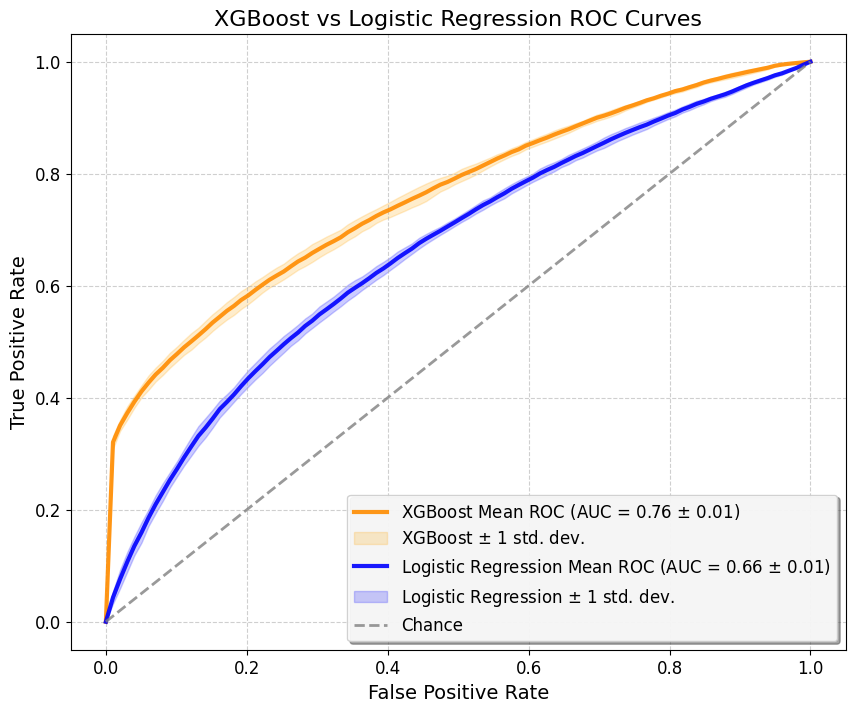

C:\Users\60304\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\60304\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.77      0.71     30000
           1       0.73      0.61      0.66     30000

    accuracy                           0.69     60000
   macro avg       0.69      0.69      0.69     60000
weighted avg       0.69      0.69      0.69     60000

XGBoost Confusion Matrix:
[[23168  6832]
 [11808 18192]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.67      0.64     30000
           1       0.64      0.57      0.60     30000

    accuracy                           0.62     60000
   macro avg       0.62      0.62      0.62     60000
weighted avg       0.62      0.62      0.62     60000

Logistic Regression Confusion Matrix:
[[20097  9903]
 [12752 17248]]


C:\Users\60304\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import shap

# Assume loocv_casualty is your original DataFrame
# Separate the majority and minority classes
df_majority = loocv_casualty[loocv_casualty.casualty_severity != 1]
df_minority = loocv_casualty[loocv_casualty.casualty_severity == 1]

# Randomly undersample the majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # No replacement
                                   n_samples=30000,  # Control the number of majority class samples
                                   random_state=123) # Random seed for reproducibility

# Combine the minority class with the downsampled majority class
gdf_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display the new class distribution
print(gdf_downsampled.casualty_severity.value_counts())

# Drop unnecessary columns
columns_to_drop = ['accident_index', 'location_easting_osgr', 'location_northing_osgr', 
                   'longitude', 'latitude', 'accident_severity_Slight', 'accident_severity_Serious', 'lsoa_of_accident_location']
casualty2 = gdf_downsampled.drop(columns=columns_to_drop)

# Separate features and labels, keeping LAD11NM as a grouping identifier
X = casualty2.drop(columns=['casualty_severity', 'LAD11NM'])
y = casualty2['casualty_severity']
groups = casualty2['LAD11NM']

# Encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)  # Use one-hot encoding

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_encoded, y)

# Assign the original LAD11NM information to the newly generated SMOTE samples using the nearest neighbors method
nbrs = NearestNeighbors(n_neighbors=1).fit(X_encoded)
distances, indices = nbrs.kneighbors(X_smote)

# Add the assigned LAD11NM information to the SMOTE-generated data
lad_smote = groups.iloc[indices.flatten()].values
X_smote_with_lad = pd.DataFrame(X_smote, columns=X_encoded.columns)
X_smote_with_lad['LAD11NM'] = lad_smote

# Final X and y for GroupKFold
X_final = X_smote_with_lad.drop(columns=['LAD11NM'])
y_final = y_smote
groups_final = X_smote_with_lad['LAD11NM']

# MDA-selected features
mda_selected_features = ['casualty_class_Pedestrian',
 'age_of_casualty',
 'avg_age_of_vehicle',
 'number_of_vehicles',
 'Index of Multiple Deprivation (IMD) Score',
 'avg_age_of_driver',
 'pop_density',
 'light_conditions_Night_time_light',                      
 'bus_stop_count',
 'shops_count',
 'road_type_Single',
 'speed_limit',
 'pedestrian_crossing_physical_facilities_pedestrian_light_controlled',
 'junction_detail_not_junction',
 'urban_or_rural_area_Urban',
 'casualty_class_Passenger',
 'junction_detail_T_junction',
 'first_road_class_Unclassified',
 'day_of_week_Weekend',
 'pedestrian_crossing_physical_facilities_Zebra',
 'weather_conditions_Raining/Snowing',
 'road_type_Other',
 'light_conditions_Night_time_nolight',
 'junction_detail_Other_junction',
 'first_road_class_C_Road',
 'first_road_class_B_Road',
 'pedestrian_crossing_physical_facilities_Others']
X_final = X_final[mda_selected_features]

# Build XGBoost and Logistic Regression models
xgb_model = xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=1.02)
logreg_model = LogisticRegression(max_iter=200)

# Set up GroupKFold for cross-validation
gkf = GroupKFold(n_splits=5)

# Prepare lists to store SHAP values
shap_values_list = []
X_list = []

# Prepare variables to store ROC curve metrics for XGBoost and Logistic Regression
xgb_tprs = []
logreg_tprs = []
xgb_aucs = []
logreg_aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

# Cross-validation
for i, (train_index, test_index) in enumerate(gkf.split(X_final, y_final, groups=groups_final)):
    # Train and test split
    X_train, X_test = X_final.iloc[train_index], X_final.iloc[test_index]
    y_train, y_test = y_final.iloc[train_index], y_final.iloc[test_index]
    
    # XGBoost model training and prediction
    xgb_model.fit(X_train, y_train)
    xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
    xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_proba)
    xgb_roc_auc = auc(xgb_fpr, xgb_tpr)
    xgb_aucs.append(xgb_roc_auc)
    xgb_tprs.append(np.interp(mean_fpr, xgb_fpr, xgb_tpr))
    xgb_tprs[-1][0] = 0.0
    
    # Logistic Regression model training and prediction
    logreg_model.fit(X_train, y_train)
    logreg_proba = logreg_model.predict_proba(X_test)[:, 1]
    logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_proba)
    logreg_roc_auc = auc(logreg_fpr, logreg_tpr)
    logreg_aucs.append(logreg_roc_auc)
    logreg_tprs.append(np.interp(mean_fpr, logreg_fpr, logreg_tpr))
    logreg_tprs[-1][0] = 0.0
    
    # Calculate and store SHAP values
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_test)
    shap_values_list.append(shap_values)
    X_list.append(X_test)

# Calculate and plot XGBoost mean ROC curve
xgb_mean_tpr = np.mean(xgb_tprs, axis=0)
xgb_mean_tpr[-1] = 1.0
xgb_mean_auc = auc(mean_fpr, xgb_mean_tpr)
xgb_std_auc = np.std(xgb_aucs)

plt.plot(mean_fpr, xgb_mean_tpr, color='darkorange', linestyle='-', 
         label=r'XGBoost Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (xgb_mean_auc, xgb_std_auc),
         lw=3, alpha=0.9)

# Plot XGBoost AUC shaded region
xgb_std_tpr = np.std(xgb_tprs, axis=0)
xgb_tprs_upper = np.minimum(xgb_mean_tpr + xgb_std_tpr, 1)
xgb_tprs_lower = np.maximum(xgb_mean_tpr - xgb_std_tpr, 0)
plt.fill_between(mean_fpr, xgb_tprs_lower, xgb_tprs_upper, color='orange', alpha=0.2,
                 label=r'XGBoost $\pm$ 1 std. dev.')

# Calculate and plot Logistic Regression mean ROC curve
logreg_mean_tpr = np.mean(logreg_tprs, axis=0)
logreg_mean_tpr[-1] = 1.0
logreg_mean_auc = auc(mean_fpr, logreg_mean_tpr)
logreg_std_auc = np.std(logreg_aucs)

plt.plot(mean_fpr, logreg_mean_tpr, color='blue', linestyle='-', 
         label=r'Logistic Regression Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (logreg_mean_auc, logreg_std_auc),
         lw=3, alpha=0.9)

# Plot Logistic Regression AUC shaded region
logreg_std_tpr = np.std(logreg_tprs, axis=0)
logreg_tprs_upper = np.minimum(logreg_mean_tpr + logreg_std_tpr, 1)
logreg_tprs_lower = np.maximum(logreg_mean_tpr - logreg_std_tpr, 0)
plt.fill_between(mean_fpr, logreg_tprs_lower, logreg_tprs_upper, color='blue', alpha=0.2,
                 label=r'Logistic Regression $\pm$ 1 std. dev.')

# Plot reference line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', alpha=0.8, label='Chance')

# Set plot formatting
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('XGBoost vs Logistic Regression ROC Curves', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)

# Optimize legend display
plt.legend(loc="lower right", fontsize=12, frameon=True, shadow=True, fancybox=True, framealpha=0.9)

# Display the plot
plt.grid(True, linestyle='--', alpha=0.6)
# plt.savefig('Output/ROC.png', dpi=300, bbox_inches='tight')
plt.show()

# Use cross-validation to make predictions (here using GroupKFold instead of StratifiedKFold)
y_pred_xgb = cross_val_predict(xgb_model, X_final, y_final, cv=gkf, groups=groups_final)
y_pred_logreg = cross_val_predict(logreg_model, X_final, y_final, cv=gkf, groups=groups_final)

# Output XGBoost classification report and confusion matrix
print("XGBoost Classification Report:")
print(classification_report(y_final, y_pred_xgb))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_final, y_pred_xgb))

# Output Logistic Regression classification report and confusion matrix
print("Logistic Regression Classification Report:")
print(classification_report(y_final, y_pred_logreg))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_final, y_pred_logreg))


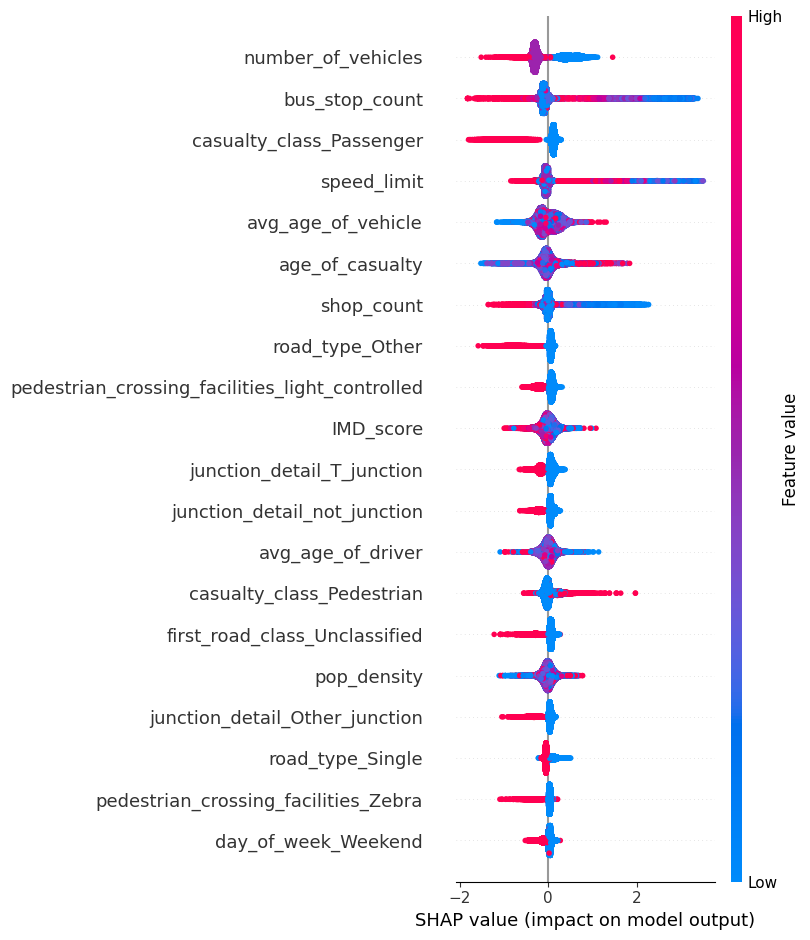

In [14]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

shap_values_all = np.concatenate(shap_values_list, axis=0)
X_all = pd.concat(X_list, axis=0)

# Update column names
new_column_names = {
    'Index of Multiple Deprivation (IMD) Score': 'IMD_score',
    'light_conditions_Night_time_light': 'light_conditions_Night_with_light',
    'shops_count': 'shop_count',
    'pedestrian_crossing_physical_facilities_pedestrian_light_controlled': 'pedestrian_crossing_facilities_light_controlled',
    'pedestrian_crossing_physical_facilities_Zebra': 'pedestrian_crossing_facilities_Zebra',
    'pedestrian_crossing_physical_facilities_Others': 'pedestrian_crossing_facilities_Others'
    # Add more column name mappings if needed
}
X_all.rename(columns=new_column_names, inplace=True)

# Ensure the feature_names list is also updated
feature_names = [new_column_names.get(name, name) for name in X_final.columns]

# Plot SHAP summary plot
plt.figure(figsize=(20, 20))
shap.summary_plot(shap_values_all, X_all, feature_names=feature_names, show=False)

# Save the image
plt.savefig('Output/shap_summary_plot.png', dpi=300, bbox_inches='tight')


In [15]:
shap_values = shap_values_all
feature_names = X_all.columns.tolist()

# Calculate the mean SHAP values (including positive and negative directions)
mean_shap_values = np.mean(shap_values, axis=0)

# Create a DataFrame to store the results
feature_importance_with_direction = pd.DataFrame({
    'Feature': feature_names,
    'Mean SHAP Value': mean_shap_values,  # Includes both positive and negative directions
    'Mean Absolute SHAP Value': np.mean(np.abs(shap_values), axis=0)  # Includes absolute values
})

# Sort the features by the magnitude of the absolute SHAP values
feature_importance_with_direction = feature_importance_with_direction.sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Reset the index
feature_importance_with_direction.reset_index(drop=True, inplace=True)

# Print feature importance (including direction)
feature_importance_with_direction.to_csv('Output/feature_importance_shap_values.csv', index=False)
feature_importance_with_direction

,Feature,Mean SHAP Value,Mean Absolute SHAP Value
0,number_of_vehicles,-0.030098,0.379021
1,bus_stop_count,0.102361,0.309626
2,casualty_class_Passenger,-0.004970,0.222345
3,speed_limit,0.104976,0.220513
4,avg_age_of_vehicle,0.002802,0.181839
5,age_of_casualty,0.000182,0.173525
6,shop_count,0.049233,0.150475
7,road_type_Other,-0.006177,0.120549
8,pedestrian_crossing_facilities_light_controlled,0.002134,0.113320
9,IMD_score,-0.004215,0.110928


# predict

In [16]:
df_2023 = pd.read_csv('london_traffic_accidents_onehot2023_with_LAD11NM.csv')

In [17]:
df_2023['urban_or_rural_area_Urban'] = 1

In [18]:
df_2023

,accident_index,age_of_casualty,casualty_severity,location_easting_osgr,location_northing_osgr,longitude,latitude,lsoa_of_accident_location,number_of_vehicles,speed_limit,...,light_conditions_Night_time_nolight,weather_conditions_Fog,weather_conditions_Raining/Snowing,junction_detail_Other_junction,junction_detail_Roundabout,junction_detail_T_junction,junction_detail_not_junction,LSOA11CD,LAD11NM,urban_or_rural_area_Urban
0,2023010419171,20.0,0,525060.0,170416.0,-0.202878,51.418974,E01003383,1,20.0,...,0,0,0,1,0,0,0,E01003383,Merton,1
1,2023010419183,25.0,0,535463.0,198745.0,-0.042464,51.671155,E01001547,3,30.0,...,0,0,0,0,0,1,0,E01001547,Enfield,1
2,2023010419183,38.0,0,535463.0,198745.0,-0.042464,51.671155,E01001547,3,30.0,...,0,0,0,0,0,1,0,E01001547,Enfield,1
3,2023010419189,50.0,0,508702.0,177696.0,-0.435789,51.487777,E01002448,2,30.0,...,0,0,0,0,1,0,0,E01002448,Hillingdon,1
4,2023010419191,34.0,0,520341.0,190175.0,-0.263972,51.597575,E01000129,2,30.0,...,0,0,0,0,0,1,0,E01000129,Barnet,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11587,2023481369636,35.0,0,531715.0,181456.0,-0.103115,51.516680,E01032740,2,20.0,...,0,0,1,0,0,1,0,E01032740,City of London,1
11588,2023481369643,31.0,0,533314.0,181658.0,-0.080008,51.518121,E01032739,2,20.0,...,0,0,0,0,0,0,1,E01032739,City of London,1
11589,2023481369648,24.0,0,532802.0,180541.0,-0.087803,51.508203,E01032739,2,20.0,...,0,0,0,0,0,0,1,E01032739,City of London,1
11590,2023481369657,39.0,0,531378.0,181561.0,-0.107930,51.517702,E01032740,2,20.0,...,0,0,0,1,0,0,0,E01032740,City of London,1


In [19]:
df_2023_new = df_2023.copy()

In [20]:
mda_selected_features = ['casualty_class_Pedestrian',
 'age_of_casualty',
 'avg_age_of_vehicle',
 'number_of_vehicles',
 'Index of Multiple Deprivation (IMD) Score',
 'avg_age_of_driver',
 'pop_density',
 'light_conditions_Night_time_light',                      
 'bus_stop_count',
 'shops_count',
 'road_type_Single',
 'speed_limit',
 'pedestrian_crossing_physical_facilities_pedestrian_light_controlled',
 'junction_detail_not_junction',
'urban_or_rural_area_Urban',
'casualty_class_Passenger',
'junction_detail_T_junction',
'first_road_class_Unclassified',
'day_of_week_Weekend',
'pedestrian_crossing_physical_facilities_Zebra',
'weather_conditions_Raining/Snowing',
'road_type_Other',
'light_conditions_Night_time_nolight',
'junction_detail_Other_junction',
'first_road_class_C_Road',
'first_road_class_B_Road',
'pedestrian_crossing_physical_facilities_Others']
X_final_mda = X_final[mda_selected_features]

In [21]:
X_all_train = X_final[mda_selected_features]
y_all_train = y_final

In [22]:
X = df_2023[mda_selected_features]
y = df_2023['casualty_severity']

In [23]:
# Normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

continuous_vars = [
    'age_of_casualty', 'number_of_vehicles',
    'avg_age_of_vehicle', 'avg_age_of_driver',
    'Index of Multiple Deprivation (IMD) Score', 'pop_density',
    'bus_stop_count', 'speed_limit'
]

# Select these continuous variables from the DataFrame
features = X[continuous_vars]

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

X[continuous_vars] = scaler.fit_transform(features)


C:\Users\60304\AppData\Local\Temp\ipykernel_19936\461224783.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[continuous_vars] = scaler.fit_transform(features)


In [24]:
# Normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

continuous_vars = [
    'age_of_casualty','number_of_vehicles',
       'avg_age_of_vehicle', 'avg_age_of_driver',
       'Index of Multiple Deprivation (IMD) Score', 'pop_density',
       'bus_stop_count','speed_limit'
]

# Select these continuous variables from the DataFrame
features = X_all_train[continuous_vars]

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

X_all_train[continuous_vars] = scaler.fit_transform(features)

In [25]:
X_all_train_and_2023 = pd.concat([X_all_train,X])
y_all_train_and_2023 = pd.concat([y_all_train,y])

In [27]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],  # Maximum depth of the tree
    'min_child_weight': [1, 3, 5],  # Minimum child weight
    'gamma': [0, 0.1, 0.3],  # Minimum loss reduction required to make a split
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 1.0],  # Subsample ratio of features for each tree
    'scale_pos_weight': [5.0, 5.17, 5.5],  # Weight for class 1
    'learning_rate': [0.01, 0.1, 0.2]  # Learning rate
}

# Build the XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss')

# Use grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=5, verbose=1, n_jobs=1)

# Train the model
grid_search.fit(X_all_train_and_2023, y_all_train_and_2023)

# Get the best model
best_model = grid_search.best_estimator_

# Predict test data and get prediction probabilities
y_pred_proba = best_model.predict_proba(X)[:, 1]

# Make classification predictions based on a custom threshold (e.g., 0.3)
threshold = 0.5
y_pred = (y_pred_proba > threshold).astype(int)

# Evaluate the model
print("Best Parameters found by Grid Search:")
print(grid_search.best_params_)

print("\nClassification Report:")
print(classification_report(y, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters found by Grid Search:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'scale_pos_weight': 5.0, 'subsample': 1.0}

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      9712
           1       0.42      0.85      0.57      1880

    accuracy                           0.79     11592
   macro avg       0.69      0.81      0.71     11592
weighted avg       0.88      0.79      0.81     11592


Confusion Matrix:
[[7547 2165]
 [ 286 1594]]


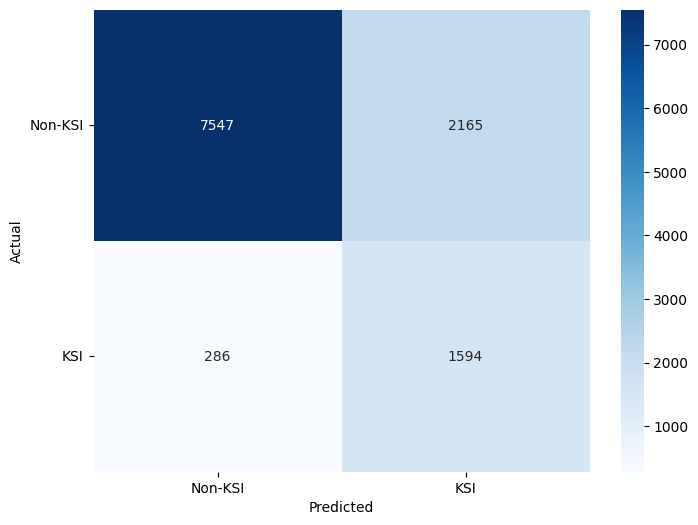

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for the confusion matrix
confusion_matrix = np.array([[7547,2165],[286,1594]])

# Creating the plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
# plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(ticks=np.arange(2) + 0.5, labels=['Non-KSI', 'KSI'])
plt.yticks(ticks=np.arange(2) + 0.5, labels=['Non-KSI', 'KSI'], rotation=0)

plt.savefig('Output/Confusion_Matrix_2023.png')
plt.show()


# all borough 2023

In [29]:
df_2023_new 

,accident_index,age_of_casualty,casualty_severity,location_easting_osgr,location_northing_osgr,longitude,latitude,lsoa_of_accident_location,number_of_vehicles,speed_limit,...,light_conditions_Night_time_nolight,weather_conditions_Fog,weather_conditions_Raining/Snowing,junction_detail_Other_junction,junction_detail_Roundabout,junction_detail_T_junction,junction_detail_not_junction,LSOA11CD,LAD11NM,urban_or_rural_area_Urban
0,2023010419171,20.0,0,525060.0,170416.0,-0.202878,51.418974,E01003383,1,20.0,...,0,0,0,1,0,0,0,E01003383,Merton,1
1,2023010419183,25.0,0,535463.0,198745.0,-0.042464,51.671155,E01001547,3,30.0,...,0,0,0,0,0,1,0,E01001547,Enfield,1
2,2023010419183,38.0,0,535463.0,198745.0,-0.042464,51.671155,E01001547,3,30.0,...,0,0,0,0,0,1,0,E01001547,Enfield,1
3,2023010419189,50.0,0,508702.0,177696.0,-0.435789,51.487777,E01002448,2,30.0,...,0,0,0,0,1,0,0,E01002448,Hillingdon,1
4,2023010419191,34.0,0,520341.0,190175.0,-0.263972,51.597575,E01000129,2,30.0,...,0,0,0,0,0,1,0,E01000129,Barnet,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11587,2023481369636,35.0,0,531715.0,181456.0,-0.103115,51.516680,E01032740,2,20.0,...,0,0,1,0,0,1,0,E01032740,City of London,1
11588,2023481369643,31.0,0,533314.0,181658.0,-0.080008,51.518121,E01032739,2,20.0,...,0,0,0,0,0,0,1,E01032739,City of London,1
11589,2023481369648,24.0,0,532802.0,180541.0,-0.087803,51.508203,E01032739,2,20.0,...,0,0,0,0,0,0,1,E01032739,City of London,1
11590,2023481369657,39.0,0,531378.0,181561.0,-0.107930,51.517702,E01032740,2,20.0,...,0,0,0,1,0,0,0,E01032740,City of London,1


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

def predict_and_save(df, model, features, threshold=0.5):
    """
    Use the specified model to make predictions on the given DataFrame and save the prediction results to a new column.

    Parameters:
    - df: pandas DataFrame, contains the data to predict
    - model: trained model
    - features: list of str, feature column names used for prediction
    - threshold: float, threshold used to convert prediction probabilities to class labels

    Returns:
    - df: DataFrame with prediction results
    """
    # Ensure that the specified feature columns are present in the DataFrame
    if not all(feature in df.columns for feature in features):
        raise ValueError("Some features specified are not in the DataFrame")
    
    # Predict probabilities using the model
    # Normalization
    from sklearn.preprocessing import MinMaxScaler
    
    continuous_vars = [
        'age_of_casualty', 'number_of_vehicles',
        'avg_age_of_vehicle', 'avg_age_of_driver',
        'Index of Multiple Deprivation (IMD) Score', 'pop_density',
        'bus_stop_count', 'speed_limit'
    ]
    
    # Select these continuous variables from the DataFrame
    continuous_features = df[continuous_vars]
    
    # Instantiate MinMaxScaler
    scaler = MinMaxScaler()
    
    df[continuous_vars] = scaler.fit_transform(continuous_features)
    
    # Make predictions using the model
    y_pred_proba = model.predict_proba(df[features])[:, 1]
    
    # Apply threshold to convert probabilities to class labels
    df['predicted_label'] = (y_pred_proba > threshold).astype(int)
    
    return df

def calculate_classification_report_by_region(df, region_column, label_column='casualty_severity', predicted_column='predicted_label'):
    """
    Calculate classification report by region.

    Parameters:
    - df: pandas DataFrame, contains region data, true labels, and predicted labels
    - region_column: str, name of the column representing the region
    - label_column: str, name of the column representing the true labels
    - predicted_column: str, name of the column representing the predicted labels

    Returns:
    - classification_reports_by_region: dict, classification report for each region
    """
    classification_reports_by_region = {}
    regions = df[region_column].unique()
    
    for region in regions:
        region_df = df[df[region_column] == region]
        report = classification_report(region_df[label_column], region_df[predicted_column], output_dict=True)
        classification_reports_by_region[region] = report
    
    return classification_reports_by_region

# Call the function to make predictions
df_2023_pred = predict_and_save(df_2023_new, best_model, mda_selected_features, threshold=0.5)

# Assume df_2023 already has a 'true_label' column representing the true class labels
classification_reports_by_region = calculate_classification_report_by_region(df_2023_pred, 'LAD11NM')

# Output the classification report for each region
for region, report in classification_reports_by_region.items():
    print(f"Classification Report for Region {region}:")
    print(pd.DataFrame(report))  # Display as a DataFrame for better readability
    print("\n")


In [32]:
pd.DataFrame(classification_reports_by_region)

,Merton,Enfield,Hillingdon,Barnet,Wandsworth,Camden,Southwark,Newham,Haringey,Hounslow,...,Harrow,Richmond upon Thames,Croydon,Hammersmith and Fulham,Kingston upon Thames,Tower Hamlets,Bromley,Sutton,Greenwich,City of London
0,"{'precision': 0.9459459459459459, 'recall': 0....","{'precision': 0.977961432506887, 'recall': 0.8...","{'precision': 0.9758620689655172, 'recall': 0....","{'precision': 0.9737827715355806, 'recall': 0....","{'precision': 0.9545454545454546, 'recall': 0....","{'precision': 0.9637305699481865, 'recall': 0....","{'precision': 0.9454022988505747, 'recall': 0....","{'precision': 0.9856262833675564, 'recall': 0....","{'precision': 0.9741935483870968, 'recall': 0....","{'precision': 0.9666666666666667, 'recall': 0....",...,"{'precision': 0.9607843137254902, 'recall': 0....","{'precision': 0.9166666666666666, 'recall': 0....","{'precision': 0.9515669515669516, 'recall': 0....","{'precision': 0.9104477611940298, 'recall': 0....","{'precision': 0.97, 'recall': 0.78225806451612...","{'precision': 0.9684466019417476, 'recall': 0....","{'precision': 0.9558823529411765, 'recall': 0....","{'precision': 0.9453125, 'recall': 0.785714285...","{'precision': 0.9685314685314685, 'recall': 0....","{'precision': 1.0, 'recall': 0.485294117647058..."
1,"{'precision': 0.47368421052631576, 'recall': 0...","{'precision': 0.3783783783783784, 'recall': 0....","{'precision': 0.4358974358974359, 'recall': 0....","{'precision': 0.3953488372093023, 'recall': 0....","{'precision': 0.3791208791208791, 'recall': 0....","{'precision': 0.39285714285714285, 'recall': 0...","{'precision': 0.5142857142857142, 'recall': 0....","{'precision': 0.47878787878787876, 'recall': 0...","{'precision': 0.3858267716535433, 'recall': 0....","{'precision': 0.5234375, 'recall': 0.893333333...",...,"{'precision': 0.3835616438356164, 'recall': 0....","{'precision': 0.43529411764705883, 'recall': 0...","{'precision': 0.4217687074829932, 'recall': 0....","{'precision': 0.4148936170212766, 'recall': 0....","{'precision': 0.47058823529411764, 'recall': 0...","{'precision': 0.536723163841808, 'recall': 0.8...","{'precision': 0.45614035087719296, 'recall': 0...","{'precision': 0.45, 'recall': 0.79411764705882...","{'precision': 0.5137614678899083, 'recall': 0....","{'precision': 0.4166666666666667, 'recall': 1...."
accuracy,0.754011,0.837553,0.820639,0.785354,0.707547,0.754098,0.801147,0.857362,0.803204,0.8125,...,0.774336,0.690608,0.795181,0.70614,0.801325,0.83871,0.77673,0.787234,0.843038,0.623656
macro avg,"{'precision': 0.7098150782361309, 'recall': 0....","{'precision': 0.6781699054426327, 'recall': 0....","{'precision': 0.7058797524314766, 'recall': 0....","{'precision': 0.6845658043724414, 'recall': 0....","{'precision': 0.6668331668331668, 'recall': 0....","{'precision': 0.6782938564026647, 'recall': 0....","{'precision': 0.7298440065681444, 'recall': 0....","{'precision': 0.7322070810777176, 'recall': 0....","{'precision': 0.6800101600203201, 'recall': 0....","{'precision': 0.7450520833333334, 'recall': 0....",...,"{'precision': 0.6721729787805533, 'recall': 0....","{'precision': 0.6759803921568628, 'recall': 0....","{'precision': 0.6866678295249724, 'recall': 0....","{'precision': 0.6626706891076533, 'recall': 0....","{'precision': 0.7202941176470588, 'recall': 0....","{'precision': 0.7525848828917778, 'recall': 0....","{'precision': 0.7060113519091847, 'recall': 0....","{'precision': 0.69765625, 'recall': 0.78991596...","{'precision': 0.7411464682106884, 'recall': 0....","{'precision': 0.7083333333333334, 'recall': 0...."
weighted avg,"{'precision': 0.8398764652634622, 'recall': 0....","{'precision': 0.9147142748983945, 'recall': 0....","{'precision': 0.8989137920172402, 'recall': 0....","{'precision': 0.8890626498413277, 'recall': 0....","{'precision': 0.8459747799370441, 'recall': 0....","{'precision': 0.8682730460739465, 'recall': 0....","{'precision': 0.8555519972873437, 'recall': 0....","{'precision': 0.9187733649720774, 'recall': 0....","{'precision

In [33]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

def predict_and_save(df, model, features, threshold=0.5):
    """
    Use the specified model to make predictions on the given DataFrame and save the prediction results to a new column.

    Parameters:
    - df: pandas DataFrame, contains the data to predict
    - model: trained model
    - features: list of str, feature column names used for prediction
    - threshold: float, threshold used to convert prediction probabilities to class labels

    Returns:
    - df: DataFrame with prediction results
    """
    # Ensure that the specified feature columns are present in the DataFrame
    if not all(feature in df.columns for feature in features):
        raise ValueError("Some features specified are not in the DataFrame")
    
    # Predict probabilities using the model
    # Normalization
    from sklearn.preprocessing import MinMaxScaler
    
    continuous_vars = [
        'age_of_casualty', 'number_of_vehicles',
        'avg_age_of_vehicle', 'avg_age_of_driver',
        'Index of Multiple Deprivation (IMD) Score', 'pop_density',
        'bus_stop_count', 'speed_limit'
    ]
    
    # Select these continuous variables from the DataFrame
    continuous_features = df[continuous_vars]
    
    # Instantiate MinMaxScaler
    scaler = MinMaxScaler()
    
    df[continuous_vars] = scaler.fit_transform(continuous_features)
    
    # Make predictions using the model
    y_pred_proba = model.predict_proba(df[features])[:, 1]
    
    # Apply threshold to convert probabilities to class labels
    df['predicted_label'] = (y_pred_proba > threshold).astype(int)
    
    return df

def calculate_classification_metrics_by_region(df, region_column, label_column='casualty_severity', predicted_column='predicted_label'):
    """
    Calculate classification metrics by region and store the results in a new DataFrame.

    Parameters:
    - df: pandas DataFrame, contains region data, true labels, and predicted labels
    - region_column: str, name of the column representing the region
    - label_column: str, name of the column representing the true labels
    - predicted_column: str, name of the column representing the predicted labels

    Returns:
    - result_df: pandas DataFrame, classification metrics and other information for each region
    """
    # Define regions for Inner London and Outer London
    inner_london_boroughs = [
        "Camden", "Greenwich", "Hackney", "Hammersmith and Fulham", "Islington",
        "Kensington and Chelsea", "Lambeth", "Lewisham", "Southwark", "Tower Hamlets",
        "Wandsworth", "Westminster", "City of London"
    ]
    
    outer_london_boroughs = [
        "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley",
        "Croydon", "Ealing", "Enfield", "Haringey", "Harrow", "Havering",
        "Hillingdon", "Hounslow", "Kingston upon Thames", "Merton",
        "Newham", "Redbridge", "Richmond upon Thames", "Sutton", "Waltham Forest"
    ]
    
    result_list = []
    regions = df[region_column].unique()
    
    for region in regions:
        region_df = df[df[region_column] == region]
        report = classification_report(region_df[label_column], region_df[predicted_column], output_dict=True)
        accuracy = accuracy_score(region_df[label_column], region_df[predicted_column])
        samples = len(region_df)
        
        # Get precision, recall, and f1-score for class 1
        precision_1 = report['1']['precision']
        recall_1 = report['1']['recall']
        f1_score_1 = report['1']['f1-score']
        
        precision_0 = report['0']['precision']
        recall_0 = report['0']['recall']
        f1_score_0 = report['0']['f1-score']
        
        # Determine if the region is Inner or Outer London
        if region in inner_london_boroughs:
            region_type = 'Inner London'
        elif region in outer_london_boroughs:
            region_type = 'Outer London'
        else:
            region_type = 'Unknown'  # If the region is not in either list
    
        # Store the results in a list
        result_list.append({
            'Region': region,
            'Precision_1': precision_1,
            'Recall_1': recall_1,
            'F1-Score_1': f1_score_1,
            'Precision_0': precision_0,
            'Recall_0': recall_0,
            'F1-Score_0': f1_score_0,
            'Accuracy': accuracy,
            'Samples': samples,
            'Region Type': region_type
        })
    
    # Convert to a DataFrame
    result_df = pd.DataFrame(result_list)
    
    return result_df

# Call the function to make predictions
df_2023_pred = predict_and_save(df_2023_new, best_model, mda_selected_features, threshold=0.5)

# Assume df_2023 already has a 'true_label' column representing the true class labels
classification_metrics_df = calculate_classification_metrics_by_region(df_2023_pred, 'LAD11NM')

classification_metrics_df.to_csv('Output/all_borough_metrics.csv')
# Output classification report results
print(classification_metrics_df)
classification_metrics_df

                    Region  Precision_1  Recall_1  F1-Score_1  Precision_0  \
0                   Merton     0.473684  0.857143    0.610169     0.945946   
1                  Enfield     0.378378  0.840000    0.521739     0.977961   
2               Hillingdon     0.435897  0.879310    0.582857     0.975862   
3                   Barnet     0.395349  0.879310    0.545455     0.973783   
4               Wandsworth     0.379121  0.862500    0.526718     0.954545   
5                   Camden     0.392857  0.862745    0.539877     0.963731   
6                Southwark     0.514286  0.825688    0.633803     0.945402   
7                   Newham     0.478788  0.918605    0.629482     0.985626   
8                 Haringey     0.385827  0.859649    0.532609     0.974194   
9                 Hounslow     0.523438  0.893333    0.660099     0.966667   
10                 Hackney     0.390244  0.872727    0.539326     0.969828   
11               Islington     0.419355  0.780000    0.545455   

,Region,Precision_1,Recall_1,F1-Score_1,Precision_0,Recall_0,F1-Score_0,Accuracy,Samples,Region Type
0,Merton,0.473684,0.857143,0.610169,0.945946,0.724138,0.820312,0.754011,187,Outer London
1,Enfield,0.378378,0.840000,0.521739,0.977961,0.837264,0.902160,0.837553,474,Outer London
2,Hillingdon,0.435897,0.879310,0.582857,0.975862,0.810888,0.885759,0.820639,407,Outer London
3,Barnet,0.395349,0.879310,0.545455,0.973783,0.769231,0.859504,0.785354,396,Outer London
4,Wandsworth,0.379121,0.862500,0.526718,0.954545,0.671512,0.788396,0.707547,424,Inner London
5,Camden,0.392857,0.862745,0.539877,0.963731,0.732283,0.832215,0.754098,305,Inner London
6,Southwark,0.514286,0.825688,0.633803,0.945402,0.794686,0.863517,0.801147,523,Inner London
7,Newham,0.478788,0.918605,0.629482,0.985626,0.848057,0.911681,0.857362,652,Outer London
8,Haringey,0.385827,0.859649,0.532609,0.974194,0.794737,0.875362,0.803204,437,Outer London
9,Hounslow,0.523438,0.893333,0.660099,0.966667,0.791809,0.870544,0.812500,368,Outer London


In [34]:
classification_metrics_df.sort_values(by=['Region Type','F1-Score_1'])

,Region,Precision_1,Recall_1,F1-Score_1,Precision_0,Recall_0,F1-Score_0,Accuracy,Samples,Region Type
15,Lewisham,0.344538,0.854167,0.491018,0.973783,0.769231,0.859504,0.779793,386,Inner London
4,Wandsworth,0.379121,0.862500,0.526718,0.954545,0.671512,0.788396,0.707547,424,Inner London
14,Lambeth,0.395722,0.831461,0.536232,0.945652,0.697861,0.803077,0.723542,463,Inner London
26,Hammersmith and Fulham,0.414894,0.764706,0.537931,0.910448,0.689266,0.784566,0.706140,228,Inner London
10,Hackney,0.390244,0.872727,0.539326,0.969828,0.750000,0.845865,0.769014,355,Inner London
5,Camden,0.392857,0.862745,0.539877,0.963731,0.732283,0.832215,0.754098,305,Inner London
11,Islington,0.419355,0.780000,0.545455,0.941489,0.766234,0.844869,0.768683,281,Inner London
16,Westminster,0.419214,0.849558,0.561404,0.946372,0.692841,0.800000,0.725275,546,Inner London
32,City of London,0.416667,1.000000,0.588235,1.000000,0.485294,0.653465,0.623656,93,Inner London
18,Kensington and Chelsea,0.463158,0.862745,0.602740,0.953642,0.738462,0.832370,0.764228,246,Inner London


# two boroughs comparison 2018-2022

In [109]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import shap

def predict_and_save(df, model, features, threshold=0.8):
    """
    Use the specified model to make predictions on the given DataFrame and save the prediction results to a new column.

    Parameters:
    - df: pandas DataFrame, contains the data to predict
    - model: trained model
    - features: list of str, feature column names used for prediction
    - threshold: float, threshold used to convert prediction probabilities to class labels

    Returns:
    - df: DataFrame with prediction results
    """
    # Ensure that the specified feature columns are present in the DataFrame
    if not all(feature in df.columns for feature in features):
        raise ValueError("Some features specified are not in the DataFrame")
    
    # Normalization
    from sklearn.preprocessing import MinMaxScaler
    
    continuous_vars = [
        'age_of_casualty', 'number_of_vehicles',
        'avg_age_of_vehicle', 'avg_age_of_driver',
        'Index of Multiple Deprivation (IMD) Score', 'pop_density',
        'bus_stop_count', 'speed_limit'
    ]
    
    # Select these continuous variables from the DataFrame
    continuous_features = df[continuous_vars]
    
    # Instantiate MinMaxScaler
    scaler = MinMaxScaler()
    
    df[continuous_vars] = scaler.fit_transform(continuous_features)
    
    # Make predictions using the model
    y_pred_proba = model.predict_proba(df[features])[:, 1]
    
    # Apply threshold to convert probabilities to class labels
    df['predicted_label'] = (y_pred_proba > threshold).astype(int)
    
    return df

def calculate_classification_metrics_by_region(df, model, features, region_column, label_column='casualty_severity', predicted_column='predicted_label'):
    """
    Calculate classification metrics by region and store the results in a new DataFrame, along with calculating SHAP values.

    Parameters:
    - df: pandas DataFrame, contains region data, true labels, and predicted labels
    - model: trained model
    - features: list of str, feature column names used for prediction
    - region_column: str, name of the column representing the region
    - label_column: str, name of the column representing the true labels
    - predicted_column: str, name of the column representing the predicted labels

    Returns:
    - result_df: pandas DataFrame, classification metrics and other information for each region
    - shap_values_by_region: dict, SHAP values for each region
    """
    target_regions = ["City of London", "Barking and Dagenham"]  # Focus only on these two regions
    
    result_list = []
    shap_values_by_region = {}
    regions = [region for region in df[region_column].unique() if region in target_regions]  # Only iterate through target regions
    
    for region in regions:
        region_df = df[df[region_column] == region]
        report = classification_report(region_df[label_column], region_df[predicted_column], output_dict=True)
        accuracy = accuracy_score(region_df[label_column], region_df[predicted_column])
        samples = len(region_df)
        
        # Get precision, recall, and f1-score for classes 0 and 1
        precision_0 = report['0']['precision']
        recall_0 = report['0']['recall']
        f1_score_0 = report['0']['f1-score']

        precision_1 = report['1']['precision']
        recall_1 = report['1']['recall']
        f1_score_1 = report['1']['f1-score']
        
        # Get macro and weighted F1 scores
        macro_f1 = report['macro avg']['f1-score']
        weighted_f1 = report['weighted avg']['f1-score']
        
        # Determine if the region is Inner or Outer London
        if region == "City of London":
            region_type = 'Inner London'
        elif region == "Barking and Dagenham":
            region_type = 'Outer London'
        else:
            region_type = 'Unknown'  # If the region is not in either list
    
        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(region_df[features])
        shap_values_by_region[region] = shap_values
        
        # Store the results in a list
        result_list.append({
            'Region': region,
            'Precision_0': precision_0,
            'Recall_0': recall_0,
            'F1-Score_0': f1_score_0,
            'Precision_1': precision_1,
            'Recall_1': recall_1,
            'F1-Score_1': f1_score_1,
            'Macro F1': macro_f1,
            'Weighted F1': weighted_f1,
            'Accuracy': accuracy,
            'Samples': samples,
            'Region Type': region_type
        })
    
    # Convert to a DataFrame
    result_df = pd.DataFrame(result_list)
    
    return result_df, shap_values_by_region

# Call the function to make predictions
df_2023_pred_two_region = predict_and_save(casualty2, best_model, mda_selected_features, threshold=0.5)

# Analyze only the City of London and Barking and Dagenham regions
classification_metrics_df, shap_values_by_region = calculate_classification_metrics_by_region(df_2023_pred_two_region, best_model, mda_selected_features, 'LAD11NM')

# Output classification report results
classification_metrics_df.to_csv('Output/performance_two_boroughs.csv')
classification_metrics_df


,Region,Precision_0,Recall_0,F1-Score_0,Precision_1,Recall_1,F1-Score_1,Macro F1,Weighted F1,Accuracy,Samples,Region Type
0,Barking and Dagenham,0.980556,0.396184,0.564349,0.413304,0.981865,0.581734,0.573041,0.569604,0.573218,1277,Outer London
1,City of London,0.944444,0.084577,0.155251,0.609342,0.996528,0.756258,0.455755,0.509219,0.621677,489,Inner London


In [104]:
df_city_of_london = df_2023_new[df_2023_new['LAD11NM'] == 'City of London']
df_barking_and_dagenham = df_2023_new[df_2023_new['LAD11NM'] == 'Barking and Dagenham']

In [ ]:
import matplotlib.pyplot as plt

# Get SHAP values for the City of London region
city_of_london_shap_values = shap_values_by_region['City of London']

# Get feature names
feature_names = mda_selected_features

# Calculate the average SHAP value for each feature in the City of London region (including positive and negative directions)
mean_shap_values_city_of_london = np.mean(city_of_london_shap_values, axis=0)

# Calculate the average absolute SHAP value for each feature in the City of London region
mean_abs_shap_values_city_of_london = np.mean(np.abs(city_of_london_shap_values), axis=0)

# Store the results in a DataFrame
city_of_london_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Mean SHAP Value': mean_shap_values_city_of_london,  # Includes both positive and negative directions
    'Mean Absolute SHAP Value': mean_abs_shap_values_city_of_london  # This represents the absolute values
})

# Sort by the magnitude of absolute SHAP values
city_of_london_feature_importance = city_of_london_feature_importance.sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Reset the index
city_of_london_feature_importance.reset_index(drop=True, inplace=True)

# Print the results
print("Feature Importance in the City of London (including direction):")
print(city_of_london_feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(city_of_london_feature_importance['Feature'], city_of_london_feature_importance['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean SHAP Value (with direction)')
plt.title('Feature Importance in City of London (SHAP Values)')
plt.gca().invert_yaxis()  # Invert the Y-axis to display the most important features at the top
plt.show()

# Analyze the directional influence of each feature
positive_features = city_of_london_feature_importance[city_of_london_feature_importance['Mean SHAP Value'] > 0]
negative_features = city_of_london_feature_importance[city_of_london_feature_importance['Mean SHAP Value'] < 0]

print("\nFeatures with a positive influence on the model output:")
print(positive_features)

print("\nFeatures with a negative influence on the model output:")
print(negative_features)

# Plot SHAP summary plot
plt.figure(figsize=(20, 20))
shap.summary_plot(city_of_london_shap_values, df_city_of_london[feature_names], feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot for City of London')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Get SHAP values for the Barking and Dagenham region
barking_and_dagenham_shap_values = shap_values_by_region['Barking and Dagenham']

# Get feature names
feature_names = mda_selected_features

# Calculate the average SHAP value for each feature in the Barking and Dagenham region (including positive and negative directions)
mean_shap_values_barking_and_dagenham = np.mean(barking_and_dagenham_shap_values, axis=0)

# Calculate the average absolute SHAP value for each feature in the Barking and Dagenham region
mean_abs_shap_values_barking_and_dagenham = np.mean(np.abs(barking_and_dagenham_shap_values), axis=0)

# Store the results in a DataFrame
barking_and_dagenham_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Mean SHAP Value': mean_shap_values_barking_and_dagenham,  # Includes both positive and negative directions
    'Mean Absolute SHAP Value': mean_abs_shap_values_barking_and_dagenham  # Represents the absolute values
})

# Sort by the magnitude of absolute SHAP values
barking_and_dagenham_feature_importance = barking_and_dagenham_feature_importance.sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Reset the index
barking_and_dagenham_feature_importance.reset_index(drop=True, inplace=True)

# Print the results
print("Feature Importance in Barking and Dagenham (including direction):")
print(barking_and_dagenham_feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(barking_and_dagenham_feature_importance['Feature'], barking_and_dagenham_feature_importance['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean SHAP Value (with direction)')
plt.title('Feature Importance in Barking and Dagenham (SHAP Values)')
plt.gca().invert_yaxis()  # Invert the Y-axis to display the most important features at the top
plt.show()

# Analyze the directional influence of each feature
positive_features = barking_and_dagenham_feature_importance[barking_and_dagenham_feature_importance['Mean SHAP Value'] > 0]
negative_features = barking_and_dagenham_feature_importance[barking_and_dagenham_feature_importance['Mean SHAP Value'] < 0]

print("\nFeatures with a positive influence on the model output:")
print(positive_features)

print("\nFeatures with a negative influence on the model output:")
print(negative_features)


Barking and Dagenham 和 City of London 区域的特征重要性：
                                            Feature  \
0                                avg_age_of_vehicle   
1                                         IMD_score   
2                                       pop_density   
3                    road_type_Complex_interchanges   
4                                number_of_vehicles   
5                    junction_detail_Other_junction   
6                         casualty_class_Pedestrian   
7                          casualty_class_Passenger   
8              pedestrian_crossing_facilities_Zebra   
9                                 road_class_C_Road   
10                                road_class_B_Road   
11              light_conditions_Night_time_nolight   
12               weather_conditions_Raining/Snowing   
13                                 road_type_Single   
14                                      speed_limit   
15            pedestrian_crossing_facilities_Others   
16               

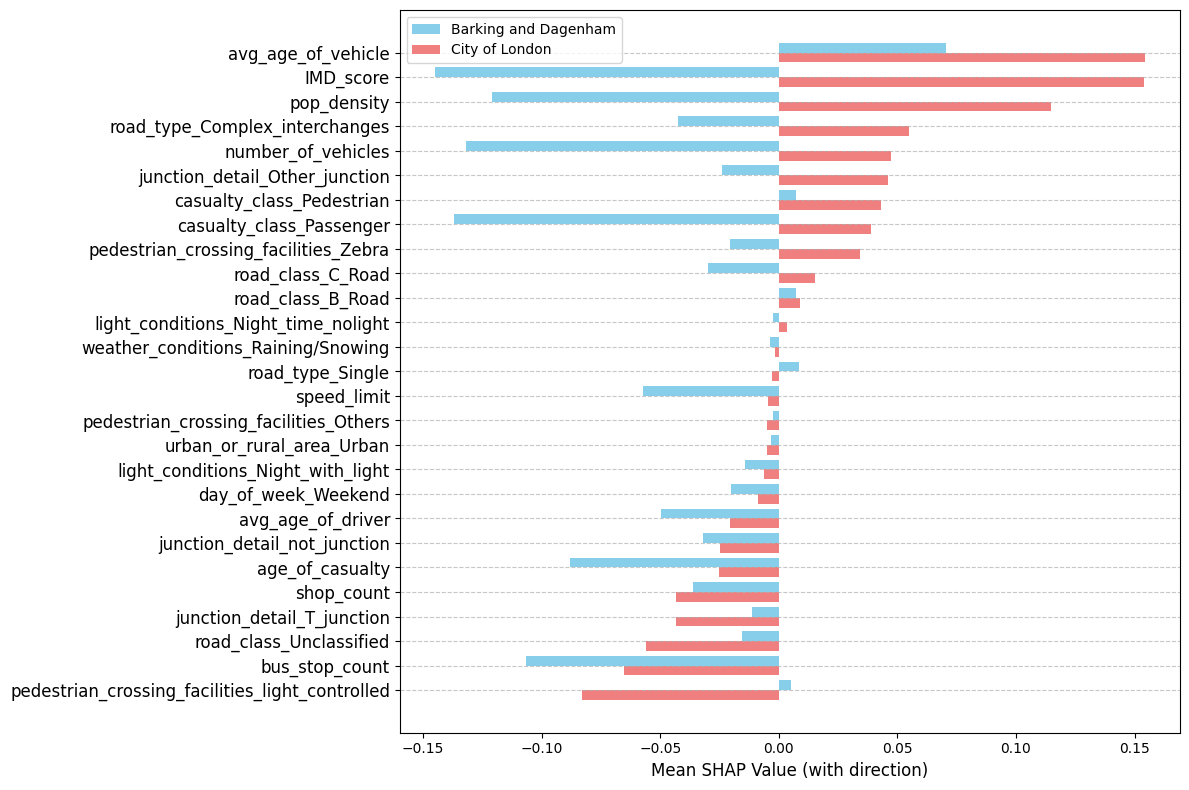

In [117]:
import matplotlib.pyplot as plt
import pandas as pd
import np
import shap

# Define the mapping for column names
new_column_names = {
    'Index of Multiple Deprivation (IMD) Score': 'IMD_score',
    'light_conditions_Night_time_light': 'light_conditions_Night_with_light',
    'shops_count': 'shop_count',
    'pedestrian_crossing_physical_facilities_pedestrian_light_controlled': 'pedestrian_crossing_facilities_light_controlled',
    'pedestrian_crossing_physical_facilities_Zebra': 'pedestrian_crossing_facilities_Zebra',
    'pedestrian_crossing_physical_facilities_Others': 'pedestrian_crossing_facilities_Others',
    'first_road_class_C_Road': 'road_class_C_Road',
    'first_road_class_B_Road': 'road_class_B_Road',
    'first_road_class_Unclassified': 'road_class_Unclassified',
    'road_type_Other': 'road_type_Complex_interchanges'
}

# Get the original feature names
feature_names = mda_selected_features

# Update feature names using the mapping
feature_names = [new_column_names.get(name, name) for name in feature_names]

# Get SHAP values for the Barking and Dagenham and City of London regions
barking_and_dagenham_shap_values = shap_values_by_region['Barking and Dagenham']
city_of_london_shap_values = shap_values_by_region['City of London']

# Calculate the average SHAP value for each feature in the Barking and Dagenham region (including positive and negative directions)
mean_shap_values_barking = np.mean(barking_and_dagenham_shap_values, axis=0)
mean_abs_shap_values_barking = np.mean(np.abs(barking_and_dagenham_shap_values), axis=0)

# Calculate the average SHAP value for each feature in the City of London region (including positive and negative directions)
mean_shap_values_city = np.mean(city_of_london_shap_values, axis=0)
mean_abs_shap_values_city = np.mean(np.abs(city_of_london_shap_values), axis=0)

# Store the results for both regions in a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean SHAP Value (Barking and Dagenham)': mean_shap_values_barking,
    'Mean SHAP Value (City of London)': mean_shap_values_city,
    'Mean Absolute SHAP Value (Barking and Dagenham)': mean_abs_shap_values_barking,
    'Mean Absolute SHAP Value (City of London)': mean_abs_shap_values_city
})

# Sort by the SHAP value for City of London in descending order
feature_importance_df = feature_importance_df.sort_values(by='Mean SHAP Value (City of London)', ascending=False)

# Reset the index
feature_importance_df.reset_index(drop=True, inplace=True)

# Print the results
print("Feature importance for Barking and Dagenham and City of London regions:")
print(feature_importance_df)

# Set the bar width
bar_width = 0.4

# Set the position for the bars
index = np.arange(len(feature_importance_df))

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the bar charts
plt.barh(index - bar_width/2, feature_importance_df['Mean SHAP Value (Barking and Dagenham)'], bar_width, color='skyblue', label='Barking and Dagenham')
plt.barh(index + bar_width/2, feature_importance_df['Mean SHAP Value (City of London)'], bar_width, color='lightcoral', label='City of London')

# Set the labels and title
plt.xlabel('Mean SHAP Value (with direction)', fontsize=12)
# plt.title('Feature Importance Comparison: Barking and Dagenham vs City of London', fontsize=15)
plt.yticks(index, feature_importance_df['Feature'], fontsize=12)  # Adjust font size for the labels on the left
plt.gca().invert_yaxis()  # Invert the Y-axis to display the most important features at the top
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add grid lines, only for the Y-axis
plt.legend()

plt.tight_layout()

plt.savefig('Output/Feature Importance Comparison_Barking and Dagenham vs City of London.png') 
# Display the plot
plt.show()


In [92]:
feature_importance_df.to_csv('./Output/feature_importance_df_bouroughs_compare.csv')

In [46]:
def predict_and_shap(df, model, features, threshold=0.5):
    """
    使用指定的模型对给定的DataFrame进行预测，并保存预测结果到新字段。

    参数:
    - df: pandas DataFrame, 包含要预测的数据
    - model: 训练好的模型
    - features: list of str, 用于预测的特征列名
    - threshold: float, 用于将预测概率转换为类别的阈值

    返回:
    - df: 带有预测结果的DataFrame
    """
    # 准备存储 SHAP 值的列表
    shap_values_list = []
    X_list = []
    # 确保输入的特征列存在于DataFrame中
    if not all(feature in df.columns for feature in features):
        raise ValueError("Some features specified are not in the DataFrame")
    
    # 使用模型预测概率
    # 归一化
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    continuous_vars = [
        'age_of_casualty','number_of_vehicles',
           'avg_age_of_vehicle', 'avg_age_of_driver',
           'Index of Multiple Deprivation (IMD) Score', 'pop_density',
           'bus_stop_count','speed_limit'
    ]
    
    # 从数据框中选取这些连续变量
    continuous_features = df[continuous_vars]
    
    # 实例化 MinMaxScaler
    scaler = MinMaxScaler()
    
    df[continuous_vars] = scaler.fit_transform(continuous_features)
    y_pred_proba = model.predict_proba(df[features])[:, 1]
    # 根据自定义阈值进行分类预测（例如0.3）
    y_pred = (y_pred_proba > threshold).astype(int)
    # 应用阈值转换概率到类别
    df['predicted_label'] = (y_pred_proba > threshold).astype(int)
    print(classification_report(df['casualty_severity'], df['predicted_label']))
        # 计算并存储 SHAP 值
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df[features])
    shap_values_list.append(shap_values)
    X_list.append(X_test)
    return df, X_list, shap_values_list

In [47]:
df_tower_hamlets_pred,X_list_tower_hamlet, shap_values_list_hamlets_pred = predict_and_shap(df_tower_hamlets, best_model, mda_selected_features, threshold=0.5)

              precision    recall  f1-score   support

           0       0.88      0.68      0.77       481
           1       0.29      0.58      0.39       108

    accuracy                           0.66       589
   macro avg       0.59      0.63      0.58       589
weighted avg       0.77      0.66      0.70       589



C:\Users\60304\AppData\Local\Temp\ipykernel_19936\2707370325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[continuous_vars] = scaler.fit_transform(continuous_features)
C:\Users\60304\AppData\Local\Temp\ipykernel_19936\2707370325.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_label'] = (y_pred_proba > threshold).astype(int)


In [48]:
df_hounslow_pred,X_list_hounslow, shap_values_list_hounslow = predict_and_shap(df_hounslow, best_model, mda_selected_features, threshold=0.5)

              precision    recall  f1-score   support

           0       0.87      0.57      0.69       293
           1       0.28      0.67      0.40        75

    accuracy                           0.59       368
   macro avg       0.58      0.62      0.54       368
weighted avg       0.75      0.59      0.63       368



C:\Users\60304\AppData\Local\Temp\ipykernel_19936\2707370325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[continuous_vars] = scaler.fit_transform(continuous_features)
C:\Users\60304\AppData\Local\Temp\ipykernel_19936\2707370325.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_label'] = (y_pred_proba > threshold).astype(int)


In [49]:
df_2023_pred[df_2023_pred['predicted_label'] == 1]

,accident_index,age_of_casualty,casualty_severity,location_easting_osgr,location_northing_osgr,longitude,latitude,lsoa_of_accident_location,number_of_vehicles,speed_limit,...,weather_conditions_Fog,weather_conditions_Raining/Snowing,junction_detail_Other_junction,junction_detail_Roundabout,junction_detail_T_junction,junction_detail_not_junction,LSOA11CD,LAD11NM,urban_or_rural_area_Urban,predicted_label
0,2023010419171,0.202020,0,525060.0,170416.0,-0.202878,51.418974,E01003383,0.000000,0.0,...,0,0,1,0,0,0,E01003383,Merton,1,1
3,2023010419189,0.505051,0,508702.0,177696.0,-0.435789,51.487777,E01002448,0.090909,0.2,...,0,0,0,1,0,0,E01002448,Hillingdon,1,1
5,2023010419192,0.242424,0,527255.0,176963.0,-0.168976,51.477324,E01004583,0.090909,0.2,...,0,0,1,0,0,0,E01004583,Wandsworth,1,1
6,2023010419198,0.656566,0,524780.0,184471.0,-0.201941,51.545349,E01000974,0.000000,0.2,...,0,0,0,0,0,1,E01000974,Camden,1,1
9,2023010419205,0.202020,0,543856.0,182912.0,0.072337,51.526805,E01003535,0.000000,0.6,...,0,0,0,0,0,1,E01003535,Newham,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11587,2023481369636,0.353535,0,531715.0,181456.0,-0.103115,51.516680,E01032740,0.090909,0.0,...,0,1,0,0,1,0,E01032740,City of London,1,1
11588,2023481369643,0.313131,0,533314.0,181658.0,-0.080008,51.518121,E01032739,0.090909,0.0,...,0,0,0,0,0,1,E01032739,City of London,1,1
11589,2023481369648,0.242424,0,532802.0,180541.0,-0.087803,51.508203,E01032739,0.090909,0.0,...,0,0,0,0,0,1,E01032739,City of London,1,1
11590,2023481369657,0.393939,0,531378.0,181561.0,-0.107930,51.517702,E01032740,0.090909,0.0,...,0,0,1,0,0,0,E01032740,City of London,1,1


In [50]:
df_2023_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11592 entries, 0 to 11591
Data columns (total 46 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   accident_index                                                       11592 non-null  int64  
 1   age_of_casualty                                                      11592 non-null  float64
 2   casualty_severity                                                    11592 non-null  int64  
 3   location_easting_osgr                                                11592 non-null  float64
 4   location_northing_osgr                                               11592 non-null  float64
 5   longitude                                                            11592 non-null  float64
 6   latitude                                                             11592 non-null  float64
 7   lsoa

# Figure and Predict 2023

In [53]:
import geopandas as gpd

# Read the boundary file for London boroughs
london_boroughs = gpd.read_file("statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")

# Use unary_union to merge the boundaries of all boroughs
london_boundary = london_boroughs.geometry.unary_union

# Create a new GeoDataFrame to store the merged boundary
london_boundary_gdf = gpd.GeoDataFrame(geometry=[london_boundary], crs=london_boroughs.crs)

# View the result
print(london_boundary_gdf)

                                            geometry
0  POLYGON ((528150.2 159979.2, 528100.9 160037.3...


C:\Users\60304\AppData\Local\Temp\ipykernel_19936\2938421859.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  london_boundary = london_boroughs.geometry.unary_union


In [61]:
# Convert accident data to a GeoDataFrame
df_2023_pred['geometry'] = gpd.points_from_xy(df_2023_pred.location_easting_osgr, df_2023_pred.location_northing_osgr)
df_2023_pred = gpd.GeoDataFrame(df_2023_pred, geometry='geometry')
casualty_map = df_2023_pred.copy()

# Filter for severe and non-severe accident data
severe_cases = casualty_map[casualty_map['predicted_label'] == 1]
non_severe_cases = casualty_map[casualty_map['predicted_label'] == 0]


In [64]:
severe_cases

,accident_index,age_of_casualty,casualty_severity,location_easting_osgr,location_northing_osgr,longitude,latitude,lsoa_of_accident_location,number_of_vehicles,speed_limit,...,weather_conditions_Raining/Snowing,junction_detail_Other_junction,junction_detail_Roundabout,junction_detail_T_junction,junction_detail_not_junction,LSOA11CD,LAD11NM,urban_or_rural_area_Urban,predicted_label,geometry
0,2023010419171,0.202020,0,525060.0,170416.0,-0.202878,51.418974,E01003383,0.000000,0.0,...,0,1,0,0,0,E01003383,Merton,1,1,POINT (525060 170416)
3,2023010419189,0.505051,0,508702.0,177696.0,-0.435789,51.487777,E01002448,0.090909,0.2,...,0,0,1,0,0,E01002448,Hillingdon,1,1,POINT (508702 177696)
5,2023010419192,0.242424,0,527255.0,176963.0,-0.168976,51.477324,E01004583,0.090909,0.2,...,0,1,0,0,0,E01004583,Wandsworth,1,1,POINT (527255 176963)
6,2023010419198,0.656566,0,524780.0,184471.0,-0.201941,51.545349,E01000974,0.000000,0.2,...,0,0,0,0,1,E01000974,Camden,1,1,POINT (524780 184471)
9,2023010419205,0.202020,0,543856.0,182912.0,0.072337,51.526805,E01003535,0.000000,0.6,...,0,0,0,0,1,E01003535,Newham,1,1,POINT (543856 182912)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11587,2023481369636,0.353535,0,531715.0,181456.0,-0.103115,51.516680,E01032740,0.090909,0.0,...,1,0,0,1,0,E01032740,City of London,1,1,POINT (531715 181456)
11588,2023481369643,0.313131,0,533314.0,181658.0,-0.080008,51.518121,E01032739,0.090909,0.0,...,0,0,0,0,1,E01032739,City of London,1,1,POINT (533314 181658)
11589,2023481369648,0.242424,0,532802.0,180541.0,-0.087803,51.508203,E01032739,0.090909,0.0,...,0,0,0,0,1,E01032739,City of London,1,1,POINT (532802 180541)
11590,2023481369657,0.393939,0,531378.0,181561.0,-0.107930,51.517702,E01032740,0.090909,0.0,...,0,1,0,0,0,E01032740,City of London,1,1,POINT (531378 181561)


In [65]:
non_severe_cases['predicted_label'] = 1
non_severe_cases

C:\Users\60304\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,accident_index,age_of_casualty,casualty_severity,location_easting_osgr,location_northing_osgr,longitude,latitude,lsoa_of_accident_location,number_of_vehicles,speed_limit,...,weather_conditions_Raining/Snowing,junction_detail_Other_junction,junction_detail_Roundabout,junction_detail_T_junction,junction_detail_not_junction,LSOA11CD,LAD11NM,urban_or_rural_area_Urban,predicted_label,geometry
1,2023010419183,0.252525,0,535463.0,198745.0,-0.042464,51.671155,E01001547,0.181818,0.2,...,0,0,0,1,0,E01001547,Enfield,1,1,POINT (535463 198745)
2,2023010419183,0.383838,0,535463.0,198745.0,-0.042464,51.671155,E01001547,0.181818,0.2,...,0,0,0,1,0,E01001547,Enfield,1,1,POINT (535463 198745)
4,2023010419191,0.343434,0,520341.0,190175.0,-0.263972,51.597575,E01000129,0.090909,0.2,...,0,0,0,1,0,E01000129,Barnet,1,1,POINT (520341 190175)
7,2023010419201,0.222222,0,532189.0,179517.0,-0.097014,51.499145,E01003927,0.090909,0.0,...,0,0,0,0,0,E01003927,Southwark,1,1,POINT (532189 179517)
8,2023010419201,0.222222,0,532189.0,179517.0,-0.097014,51.499145,E01003927,0.090909,0.0,...,0,0,0,0,0,E01003927,Southwark,1,1,POINT (532189 179517)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11577,2023481367227,0.232323,0,533358.0,181664.0,-0.079372,51.518164,E01032739,0.000000,0.0,...,0,0,0,0,1,E01032739,City of London,1,1,POINT (533358 181664)
11579,2023481367305,0.313131,0,532419.0,180820.0,-0.093214,51.510800,E01032739,0.090909,0.0,...,0,0,0,1,0,E01032739,City of London,1,1,POINT (532419 180820)
11580,2023481368775,0.343434,0,531738.0,181166.0,-0.102892,51.514069,E01032740,0.090909,0.0,...,0,0,0,1,0,E01032740,City of London,1,1,POINT (531738 181166)
11581,2023481368788,0.393939,0,533049.0,181139.0,-0.084021,51.513519,E01032739,0.090909,0.0,...,0,0,0,0,0,E01032739,City of London,1,1,POINT (533049 181139)


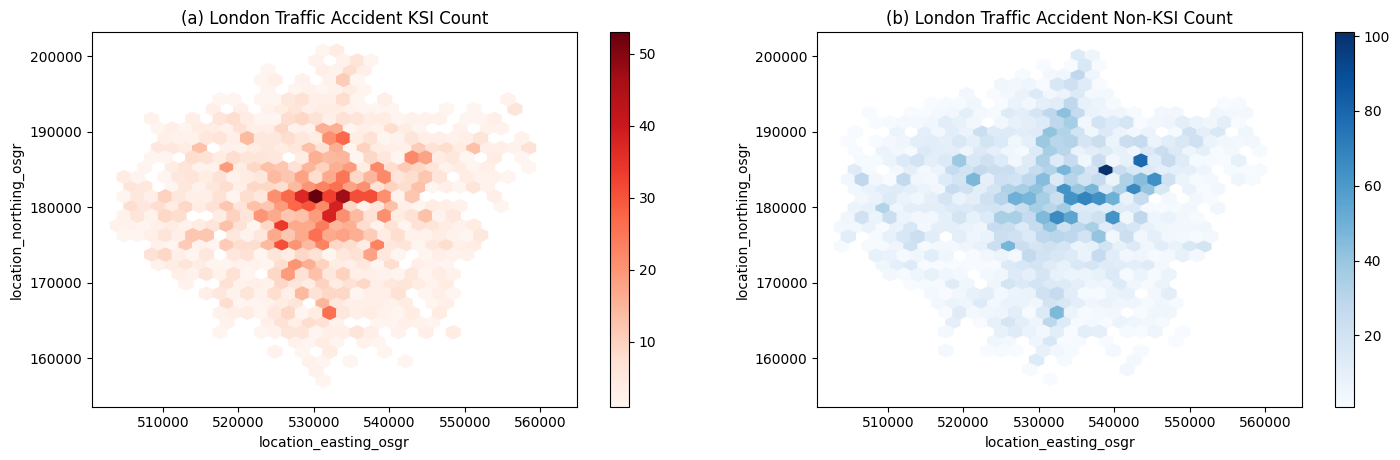

In [66]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(15, 4.5))

# Plot the boundary and a hexbin map of severe accidents on the first subplot
london_boundary_gdf.plot(ax=axs[0], color='white', edgecolor='white')
severe_cases.plot(ax=axs[0], kind='hexbin', 
                  x='location_easting_osgr', y='location_northing_osgr', 
                  C='predicted_label', 
                  reduce_C_function=np.sum, 
                  gridsize=30, cmap='Reds')

axs[0].set_title('(a) London Traffic Accident KSI Count')

# Plot the boundary and a hexbin map of non-severe accidents on the second subplot
london_boundary_gdf.plot(ax=axs[1], color='white', edgecolor='white')
non_severe_cases.plot(ax=axs[1], kind='hexbin', 
                      x='location_easting_osgr', y='location_northing_osgr', 
                      C='predicted_label', 
                      reduce_C_function=np.sum, 
                      gridsize=30, cmap='Blues')

axs[1].set_title('(b) London Traffic Accident Non-KSI Count')

plt.tight_layout()
plt.savefig('Output/hexbin_map_2023_predict.png')
plt.show()